In [2]:
!pip install gdown

In [3]:
import gdown
import zipfile
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from PIL import Image
from shutil import copy2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
# from google.colab import files, drive
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
gdown.download(f'https://drive.google.com/uc?id=1ya_MPdn9_igqH4pOqFRmJqMGSPAaWkin', '/content/', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ya_MPdn9_igqH4pOqFRmJqMGSPAaWkin
From (redirected): https://drive.google.com/uc?id=1ya_MPdn9_igqH4pOqFRmJqMGSPAaWkin&confirm=t&uuid=f4e49fd2-c5a1-4132-801d-46b9354956b2
To: /content/Motif_Batik_Dataset.zip
100%|██████████| 331M/331M [00:02<00:00, 115MB/s]


'/content/Motif_Batik_Dataset.zip'

In [5]:
# Extract the dataset
zip_ref = zipfile.ZipFile('/content/Motif_Batik_Dataset.zip', 'r')
zip_ref.extractall('/tmp/dataset')
zip_ref.close()

In [6]:
# Define Directories for Dataset
base_dir = '/tmp/dataset/Motif Batik Dataset'

train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Create directories for train, val, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class names (folder names)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Create class directories in train, val, and test folders
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

In [7]:
# Split data
for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    images = os.listdir(cls_dir)
    images = [img for img in images if os.path.isfile(os.path.join(cls_dir, img))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(train_dir, cls))
    for img in val_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(val_dir, cls))
    for img in test_imgs:
        copy2(os.path.join(cls_dir, img), os.path.join(test_dir, cls))

In [8]:
train_datagen = ImageDataGenerator( #prefer augmentasi
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

# VALIDATION_DIR = 'data/val'
validation_datagen = ImageDataGenerator(rescale = 1./255)

# TESTING_DIR = 'data/test'
testing_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300,300),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(300,300),
    class_mode='categorical',
    batch_size=32
)

testing_generator = testing_datagen.flow_from_directory(
    test_dir,
    target_size=(300,300),
    class_mode='categorical',
    batch_size=32,
)

Found 3543 images belonging to 15 classes.
Found 442 images belonging to 15 classes.
Found 449 images belonging to 15 classes.


In [9]:
# Menggunakan Transfer Learning
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(300,300,3))
base_model.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [10]:
# base_model.summary()

In [11]:
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
            # tf.keras.layers.MaxPooling2D(2,2),
            # tf.keras.layers.Flatten(),
            tf.keras.layers.GlobalAveragePooling2D(),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(15, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 256)         1179904   
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 256)         0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 256)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0

In [12]:
# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#     # This is the first convolution
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # The second convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The third convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fifth convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5), #diperbesar
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(15, activation='softmax')
# ])

# # kalo nambah dropout = memperkecil akurasi -> balikin dropout, tambah conv layer

# # Print the model summary
# model.summary()

In [13]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy']) # mainin lr

In [14]:
# Train the model
history = model.fit(train_generator, epochs=30, validation_data = validation_generator, verbose = 1) #tambah epoch, tambah early stop (=aktif -> cek akurasi&val_akurasi , kalau tdk sesuai besarkan lr)

Epoch 1/30
111/111 [==============================] - 135s 1s/step - loss: 2.0046 - accuracy: 0.3565 - val_loss: 1.4094 - val_accuracy: 0.5249
Epoch 2/30
111/111 [==============================] - 101s 909ms/step - loss: 1.3199 - accuracy: 0.5738 - val_loss: 1.0068 - val_accuracy: 0.6606
Epoch 3/30
111/111 [==============================] - 102s 920ms/step - loss: 1.0742 - accuracy: 0.6427 - val_loss: 0.9604 - val_accuracy: 0.6968
Epoch 4/30
111/111 [==============================] - 101s 907ms/step - loss: 0.9212 - accuracy: 0.6960 - val_loss: 0.7541 - val_accuracy: 0.7376
Epoch 5/30
111/111 [==============================] - 100s 896ms/step - loss: 0.8104 - accuracy: 0.7358 - val_loss: 0.7682 - val_accuracy: 0.7443
Epoch 6/30
111/111 [==============================] - 102s 912ms/step - loss: 0.7046 - accuracy: 0.7652 - val_loss: 0.6700 - val_accuracy: 0.8054
Epoch 7/30
111/111 [==============================] - 99s 892ms/step - loss: 0.6365 - accuracy: 0.7988 - val_loss: 0.6788 - val

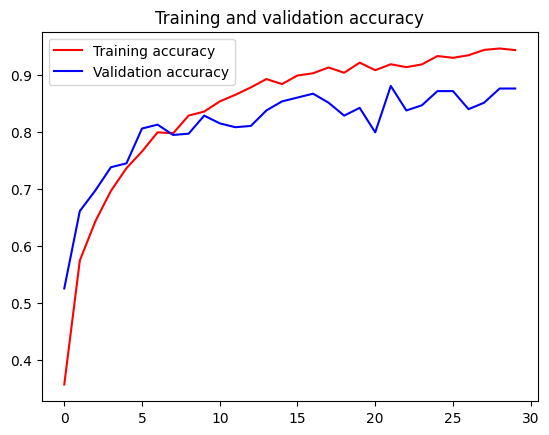

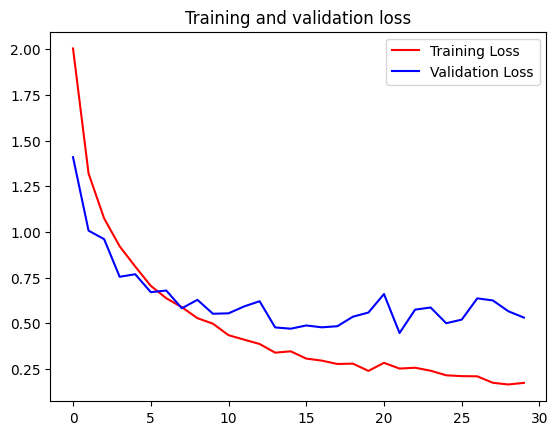

In [15]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Melakukan Prediksi
predictions = model.predict(testing_generator)
test_loss, test_accuracy = model.evaluate(testing_generator)
print(f'Test Accuracy: {test_accuracy}')

15/15 [==============================] - 4s 262ms/step - loss: 0.4877 - accuracy: 0.8886
Test Accuracy: 0.8886414170265198


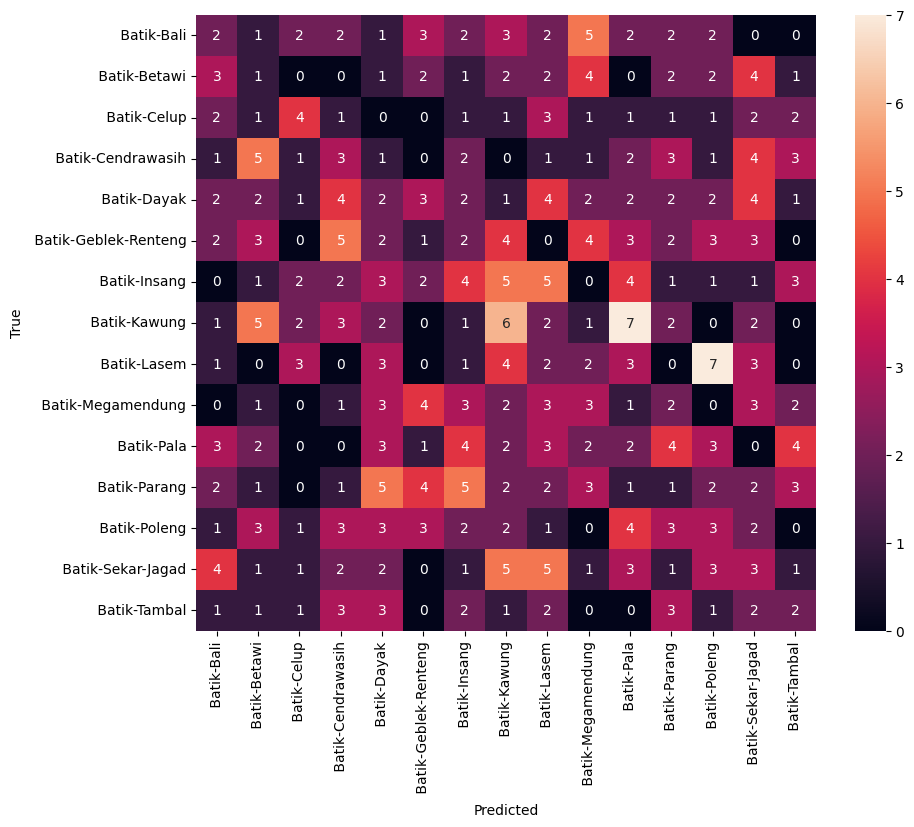

                       precision    recall  f1-score   support

           Batik-Bali       0.08      0.07      0.07        29
         Batik-Betawi       0.04      0.04      0.04        25
          Batik-Celup       0.22      0.19      0.21        21
    Batik-Cendrawasih       0.10      0.11      0.10        28
          Batik-Dayak       0.06      0.06      0.06        34
 Batik-Geblek-Renteng       0.04      0.03      0.04        34
         Batik-Insang       0.12      0.12      0.12        34
         Batik-Kawung       0.15      0.18      0.16        34
          Batik-Lasem       0.05      0.07      0.06        29
    Batik-Megamendung       0.10      0.11      0.11        28
           Batik-Pala       0.06      0.06      0.06        33
         Batik-Parang       0.03      0.03      0.03        34
         Batik-Poleng       0.10      0.10      0.10        31
    Batik-Sekar-Jagad       0.09      0.09      0.09        33
         Batik-Tambal       0.09      0.09      0.09  

In [17]:
predicted_classes = predictions.argmax(axis=-1)
true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"F1 Score: {f1}")

In [18]:
# Mendapatkan nama kelas dari generator
class_indices = train_generator.class_indices
# Membalikkan dictionary untuk mendapatkan nama kelas dari indeks
labels = {v: k for k, v in class_indices.items()}

# Mengambil label asli dari testing_generator
true_classes = testing_generator.classes
# Mendapatkan nama kelas dari label asli
true_labels = [labels[i] for i in true_classes]

# Mendapatkan nama file dari testing_generator
filenames = testing_generator.filenames

for i, pred in enumerate(predictions):
    # Membulatkan nilai probabilitas menjadi 3 angka di belakang koma
    rounded_classes = np.round(pred, 3)

    # Mendapatkan indeks kelas dengan prediksi tertinggi
    predicted_class_index = np.argmax(pred)
    predicted_class_label = labels[predicted_class_index]

    # Mendapatkan label asli dari indeks
    true_label = true_labels[i]

    print(f"File: {filenames[i]}")
    print(f"True class: {true_label}")
    print(f"Predicted class: {predicted_class_label} (index: {predicted_class_index})")
    print(f"Prediction probabilities: {rounded_classes}")
    print()

File:  Batik-Bali/13_jpg.rf.0b90768c2d77fda87182bb3b1d0cf87c.jpg
True class:  Batik-Bali
Predicted class:  Batik-Kawung (index: 7)
Prediction probabilities: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

File:  Batik-Bali/16_jpg.rf.e104c957e578718873edcf0d63f4a2ae.jpg
True class:  Batik-Bali
Predicted class:  Batik-Lasem (index: 8)
Prediction probabilities: [0.438 0.    0.    0.    0.    0.    0.    0.    0.562 0.    0.    0.
 0.    0.    0.   ]

File:  Batik-Bali/18_jpg.rf.644a263da455d3165f9237779dafe7f2.jpg
True class:  Batik-Bali
Predicted class:  Batik-Bali (index: 0)
Prediction probabilities: [0.984 0.    0.    0.006 0.    0.    0.    0.    0.009 0.    0.    0.
 0.    0.    0.   ]

File:  Batik-Bali/20_jpg.rf.e830cafd29ce68cf75e82a09cc737691.jpg
True class:  Batik-Bali
Predicted class:  Batik-Kawung (index: 7)
Prediction probabilities: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

File:  Batik-Bali/23_jpg.rf.4f59c7ad95913ec8aedab76b56f4d023.jpg
True class:  Batik-Bali
Predicte